### Mathematical Description of the System

We are modeling a simple 1D **two-state single sensor** system with a state defined by its position and velocity.

#### State Vector

The state of the system at time `k` is given by the vector $x_k$:

$$x_k = \begin{bmatrix} p_k \\ v_k \end{bmatrix}$$

where $p_k$ is the position and $v_k$ is the velocity.

#### State Transition Model (Dynamic Model)

The system evolves according to the linear equation:

$$x_k = F x_{k-1} + w_{k-1}$$

This model assumes constant velocity, updated at each time step $\Delta t$. The **state transition matrix** $F$ is derived from basic kinematics:

* $p_k = p_{k-1} + v_{k-1} \cdot \Delta t$
* $v_k = v_{k-1}$

This gives the matrix:

$$F = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}$$

The term $w_{k-1}$ is the **process noise**, a zero-mean Gaussian random vector with covariance matrix $Q$. It accounts for unmodeled dynamics, like random accelerations.

$$w_{k-1} \sim \mathcal{N}(0, Q)$$

#### Measurement Model

We assume a sensor that measures only the position. The measurement $y_k$ is related to the state $x_k$ by:

$$y_k = H x_k + v_k$$

The **measurement matrix** $H$ extracts the position from the state vector:

$$H = \begin{bmatrix} 1 & 0 \end{bmatrix}$$

The term $v_k$ is the **measurement noise**, a zero-mean Gaussian random variable with covariance (in this case, variance) $R$. It accounts for sensor inaccuracy.

$$v_k \sim \mathcal{N}(0, R)$$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Setup the Simulation ---
dt = 0.1  # Time step
num_steps = 100  # Number of steps

# Define the state transition matrix F for constant velocity model
# x = [position, velocity]ᵀ
# new_pos = old_pos + dt * old_vel
# new_vel = old_vel
F = np.array([[1, dt],
              [0, 1]])

# Define the measurement matrix H
# We only measure position
H = np.array([[1, 0]])

# Define Process Noise Covariance Q
# Represents uncertainty in the model (e.g., random accelerations)
# Check below to understand how Q is computed assuming there is random acceleration
q_std = 0.1 # 0.05
Q = np.array([[(dt**4)/4, (dt**3)/2],
              [(dt**3)/2, dt**2]]) * q_std**2


# Define Measurement Noise Covariance R
# Represents sensor inaccuracy
# This value would often come from the sensor's datasheet or
#   from analyzing sensor data experimentally like
#   keep the System Still: Place your sensor in a fixed position
#   so that the true value it's measuring (e.g., position) does not change.

r_std = 1.0
R = np.array([[r_std**2]])

### Derivation of the Process Noise (Q) Matrix

This derivation explains how the specific form of the `Q` matrix is determined from the physical assumption of a random, unmodeled acceleration.

#### 1. The Physical Model

We start with the assumption that our "constant velocity" motion model is not perfect. We model the imperfection as a continuous-time, zero-mean, white-noise acceleration, `a`, with a standard deviation of $\sigma_a$. This acceleration is not measured and is the source of our process noise.

#### 2. Effect on the State Vector

We need to determine how this random acceleration `a` affects our state vector $x = \begin{bmatrix} p \\ v \end{bmatrix}$ over a single discrete time step, $\Delta t$. From basic kinematics, the change in position and velocity is:

* **Change in Velocity:** $\Delta v = a \cdot \Delta t$
* **Change in Position:** $\Delta p = \frac{1}{2} a (\Delta t)^2$

This gives us the process noise vector, $w_k$, which is the change in the state due to this unmodeled acceleration:

$$ w_k = \begin{bmatrix} \Delta p \\ \Delta v \end{bmatrix} = \begin{bmatrix} \frac{1}{2}(\Delta t)^2 \\ \Delta t \end{bmatrix} a $$

#### 3. Calculating the Covariance (Q)

The process noise covariance matrix, $Q$, is defined as the expected value of the outer product of the noise vector with itself ($Q = E[w_k w_k^T]$).

First, let's write out the outer product $w_k w_k^T$:
$$ w_k w_k^T = \begin{bmatrix} \frac{1}{2}(\Delta t)^2 \\ \Delta t \end{bmatrix} a \cdot \left( \begin{bmatrix} \frac{1}{2}(\Delta t)^2 \\ \Delta t \end{bmatrix} a \right)^T = \begin{bmatrix} \frac{1}{2}(\Delta t)^2 \\ \Delta t \end{bmatrix} a^2 \begin{bmatrix} \frac{1}{2}(\Delta t)^2 & \Delta t \end{bmatrix} $$

Now, we perform the matrix multiplication:
$$ w_k w_k^T = \begin{bmatrix} \frac{(\Delta t)^4}{4} a^2 & \frac{(\Delta t)^3}{2} a^2 \\ \frac{(\Delta t)^3}{2} a^2 & (\Delta t)^2 a^2 \end{bmatrix} $$

Finally, we take the expected value of each term. Since `a` is the only random variable, this is equivalent to multiplying the matrix by the expected value of $a^2$, which is the variance of the acceleration, $\sigma_a^2$.

$$ Q = E[w_k w_k^T] = \begin{bmatrix} \frac{(\Delta t)^4}{4} & \frac{(\Delta t)^3}{2} \\ \frac{(\Delta t)^3}{2} & (\Delta t)^2 \end{bmatrix} E[a^2] = \begin{bmatrix} \frac{(\Delta t)^4}{4} & \frac{(\Delta t)^3}{2} \\ \frac{(\Delta t)^3}{2} & (\Delta t)^2 \end{bmatrix} \sigma_a^2 $$

This resulting matrix is precisely what is implemented in the code, where `q_std` corresponds to $\sigma_a$.

### Determining the Source of Process Noise in the Real World

This is the art of system modeling. You must think about what physical phenomena your state transition model ($x_k = Fx_{k-1}$) **fails to capture**.

#### Identify Your Model's Assumption

Our model's core assumption is `new_velocity = old_velocity`. What in the real world could violate this?

* **Example 1: A Cart on a Ramp.**
    The unmodeled force is **gravity**. Your "process noise" is actually a constant acceleration. The Kalman filter will struggle because the noise isn't random. This is a **modeling error**, and you should fix your `F` matrix to include acceleration rather than trying to account for it in `Q`.

* **Example 2: A Small Robot on the Floor.** 🤖
    The floor isn't perfectly smooth. There are tiny bumps and friction variations. These create small, random forces that look like random accelerations. Our `Q` matrix model is perfect for this scenario.

* **Example 3: A Drone Hovering.** 🚁
    Air is not static. Small gusts of wind and turbulence create random forces that affect the drone's position. This also looks like random acceleration, so our `Q` model is appropriate here.


In [ ]:
# --- 2. Generate the Toy Dataset ---
# True initial state [position, velocity]
true_x0 = np.array([[0], [1]])

# Generate true states
true_states = np.zeros((num_steps, 2, 1))
true_states[0] = true_x0
for k in range(1, num_steps):
    # Propagate true state (without process noise for a clean true line)
    true_states[k] = F @ true_states[k-1]

# Generate noisy measurements
measurements = np.zeros((num_steps, 1, 1))
for k in range(num_steps):
    noise = np.random.normal(0, r_std)
    measurements[k] = H @ true_states[k] + noise


***

### Kalman Filter Equations

The filter estimates the state $x_k$ using a two-step, predict-update cycle. The notation `⁻` denotes *a priori* (predicted) estimates, and `⁺` denotes *a posteriori* (updated) estimates.

#### 1. Predict Step

The goal is to predict the state and covariance at time `k`, based on the updated estimate from the previous step `k-1`.

* **Predict State Estimate:**
    $$\hat{x}_{k}^{-} $$
    
    $$= F \hat{x}_{k-1}^+ $$

* **Predict Error Covariance:**
    $$P_k^- = F P_{k-1}^+ F^T + Q$$

#### 2. Update Step

The goal is to correct the predicted estimate using the new measurement $y_k$.

* **Compute Kalman Gain:** The gain determines how much the prediction is corrected by the measurement.
    $$K_k = P_k^- H^T (H P_k^- H^T + R)^{-1}$$

* **Update State Estimate:** The final estimate is a blend of the prediction and the measurement innovation.
    $$\hat{x}_k^+ = \hat{x}_k^- + K_k (y_k - H \hat{x}_k^-)$$

* **Update Error Covariance:** The uncertainty in the estimate is reduced after the measurement update.
    $$P_k^+ = (I - K_k H) P_k^-$$

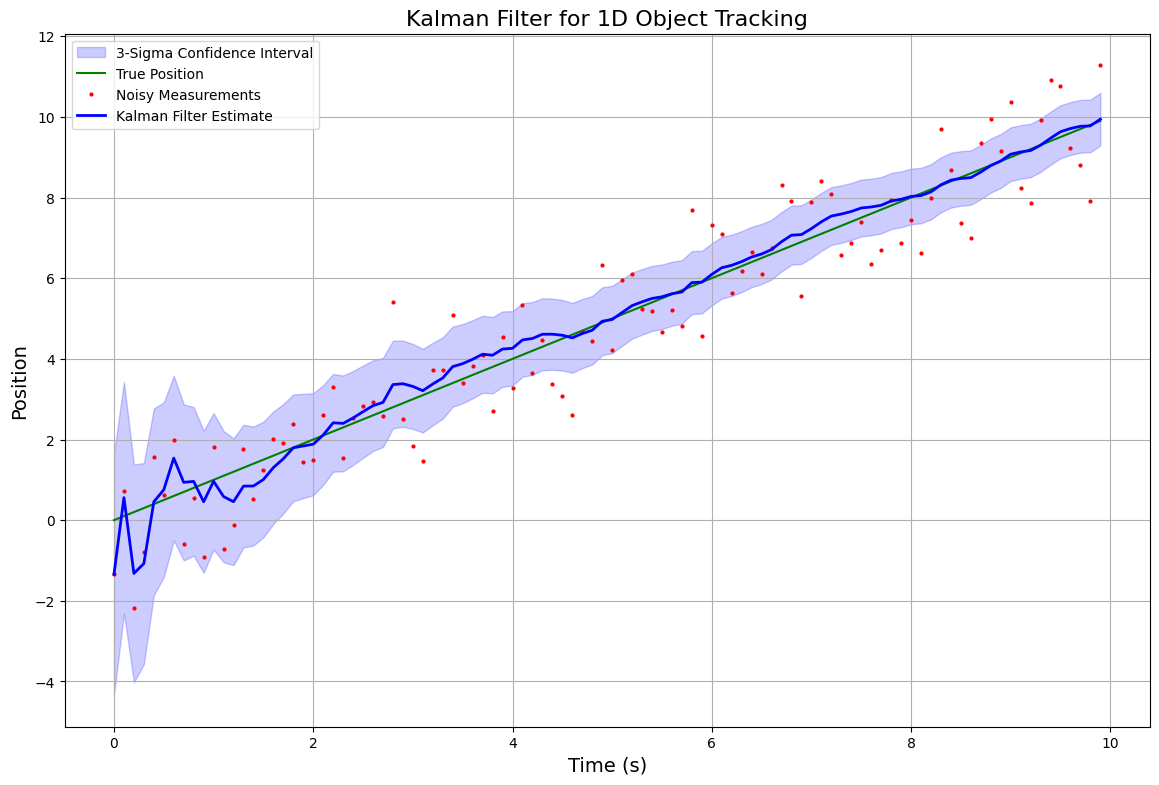

In [ ]:

def kalman_filter(y, F, H, Q, R, x0, P0):
    """
    Implements a linear Kalman filter.

    Args:
        y (np.ndarray): Array of measurements.
        F (np.ndarray): State transition matrix.
        H (np.ndarray): Measurement matrix.
        Q (np.ndarray): Process noise covariance.
        R (np.ndarray): Measurement noise covariance.
        x0 (np.ndarray): Initial state estimate.
        P0 (np.ndarray): Initial covariance estimate.

    Returns:
        (np.ndarray, np.ndarray): Tuple of state estimates and covariance estimates.
    """
    # Get dimensions
    num_steps = len(y)
    num_states = F.shape[0]
    num_measurements = H.shape[0]

    # Initialize state and covariance
    x_hat = x0
    P = P0

    # Store results
    x_estimates = np.zeros((num_steps, num_states, 1))
    P_history = np.zeros((num_steps, num_states, num_states))
    x_estimates[0] = x_hat
    P_history[0] = P
    innovation_means = np.zeros((num_steps, num_measurements, 1))
    innovation_covariances = np.zeros((num_steps, num_measurements, num_measurements))

    for k in range(num_steps):
        # --- Predict Step ---
        # Predict the state ahead: x̂_k⁻ = F * x̂_{k-1}⁺
        x_hat_minus = F @ x_hat
        # Predict the covariance ahead: P_k⁻ = F * P_{k-1}⁺ * Fᵀ + Q
        P_minus = F @ P @ F.T + Q

        # --- Update Step ---
        # Compute Kalman Gain: K_k = P_k⁻ * Hᵀ * (H * P_k⁻ * Hᵀ + R)⁻¹
        K = P_minus @ H.T @ np.linalg.inv(H @ P_minus @ H.T + R)

        # Calculate Innovation
        innovation = y[k] - H @ x_hat_minus
        innovation_means[k] = innovation
        innovation_covariances[k] = H @ P_minus @ H.T + R

        # Update estimate with measurement z_k: x̂_k⁺ = x̂_k⁻ + K_k * (z_k - H * x̂_k⁻)
        x_hat = x_hat_minus + K @ (innovation)

        # Update the error covariance: P_k⁺ = (I - K_k * H) * P_k⁻
        I = np.eye(num_states)
        P = (I - K @ H) @ P_minus

        # Store the a posteriori estimates
        x_estimates[k] = x_hat
        P_history[k] = P

    return x_estimates, P_history, innovation_means, innovation_covariances


# --- 3. Run the Kalman Filter ---
# Initial guess for the state
x0_guess = np.array([[0], [0]]) # Start with a wrong velocity guess
# Initial guess for the covariance (high uncertainty)
P0_guess = np.eye(2) * 1000

# Run the filter
filtered_states, filtered_P, innovation_means, innovation_covariances = kalman_filter(measurements, F, H, Q, R, x0_guess, P0_guess)

# --- 4. Plot the Results ---
time = np.arange(0, num_steps * dt, dt)

# Extract the position uncertainty (standard deviation) from the covariance matrix
# P[0,0] is the variance of the position. sqrt(P[0,0]) is the standard deviation.
pos_std = np.sqrt(filtered_P[:, 0, 0])

# Get the 3-sigma bounds
lower_bound = filtered_states[:, 0, 0] - 3 * pos_std
upper_bound = filtered_states[:, 0, 0] + 3 * pos_std

plt.figure(figsize=(14, 9))
# Plot the 3-sigma confidence interval
plt.fill_between(time, lower_bound, upper_bound, color='b', alpha=0.2, label='3-Sigma Confidence Interval')

plt.plot(time, true_states[:, 0], 'g-', label='True Position')
plt.plot(time, measurements[:, 0], 'r.', markersize=4, label='Noisy Measurements')
plt.plot(time, filtered_states[:, 0], 'b-', linewidth=2, label='Kalman Filter Estimate')

plt.title('Kalman Filter for 1D Object Tracking', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Position', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

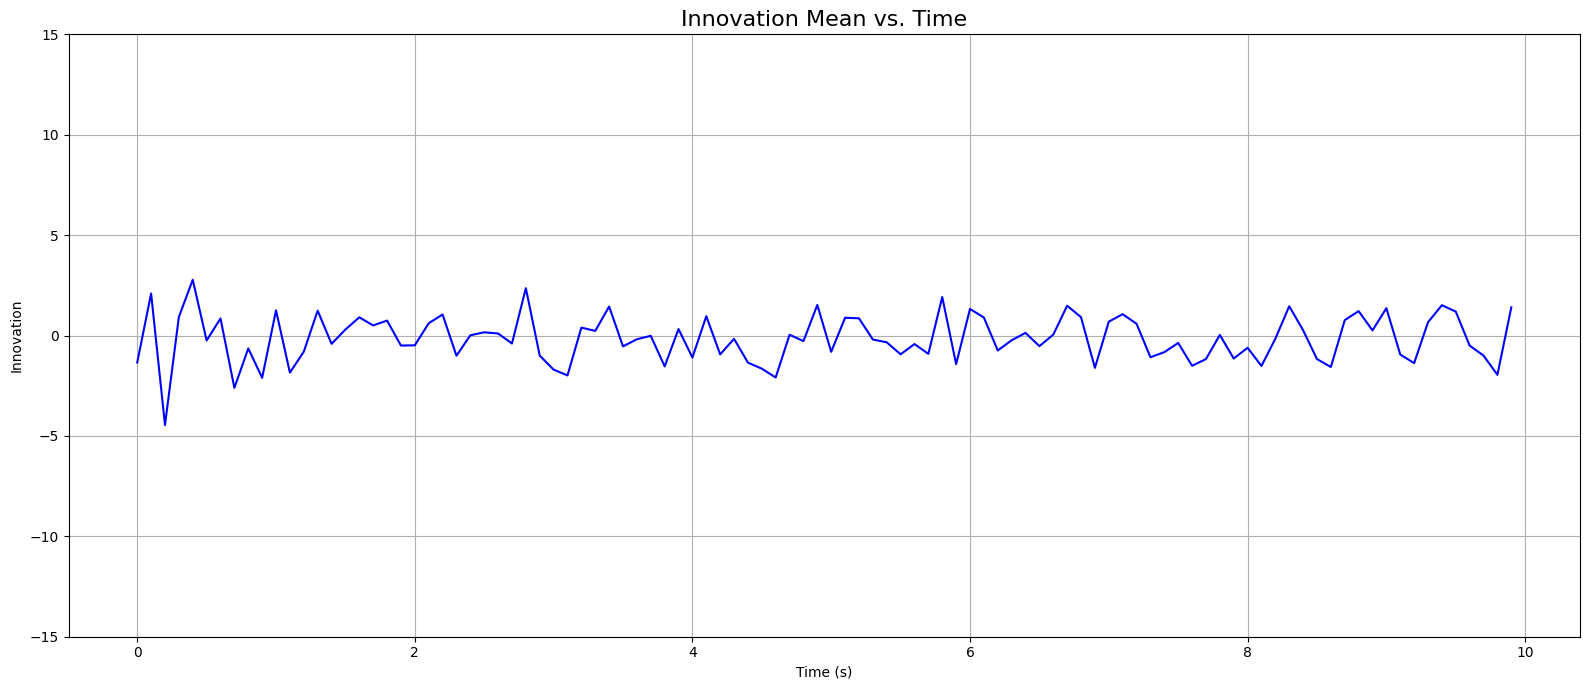

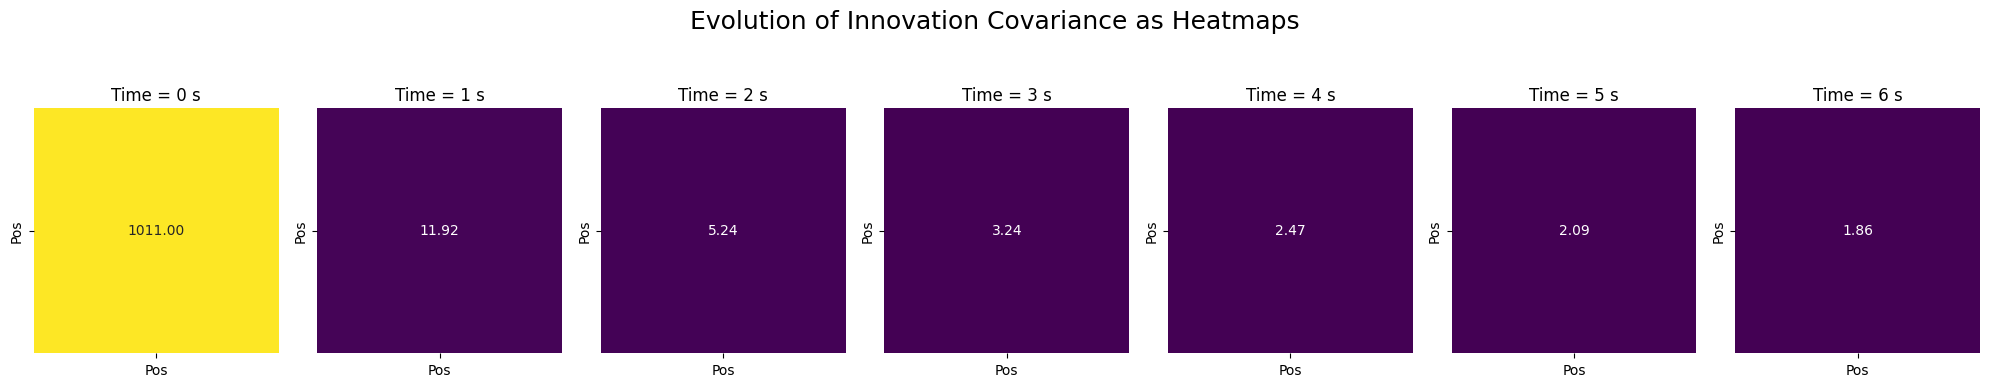

In [ ]:
import matplotlib.animation as animation
import seaborn as sns

# --- 4. Plot the Innovation ---
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 7))

# Plot 1: Innovation Mean (Static)
ax1.plot(time, innovation_means[:, 0, 0], 'b-')
ax1.set_title('Innovation Mean vs. Time', fontsize=16)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Innovation')
ax1.grid(True)
ax1.set_ylim(-15, 15) # Set fixed y-axis for better visualization

plt.tight_layout()
plt.show()

# --- 4. Plot Innovation Covariance at Different Timesteps ---
# Timesteps to plot (every 20 seconds, since dt=1.0)
plot_steps = [0, 1, 2, 3, 4, 5, 6]
num_plots = len(plot_steps)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 4))
fig.suptitle('Evolution of Innovation Covariance as Heatmaps', fontsize=18)

# Find a global min/max for consistent color scaling across all heatmaps
vmin = np.min(innovation_covariances)
vmax = np.max(innovation_covariances[0]) # Use max from the first step for scale

for i, step in enumerate(plot_steps):
    ax = axes[i]
    sns.heatmap(innovation_covariances[step], ax=ax, annot=True, fmt=".2f",
                cmap="viridis", cbar=False, vmin=vmin, vmax=vmax,
                xticklabels=['Pos'], yticklabels=['Pos'])
    ax.set_title(f'Time = {step} s')
    ax.set_aspect('equal') # Make heatmap cells square

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### The Art of Kalman Filtering: From Theory to Practice

Implementing a Kalman filter successfully requires moving beyond textbook equations and embracing the art of system modeling. While the filter's mathematical structure is elegant and proven, its performance in the real world depends entirely on how well it is configured to represent a specific physical system. A robust filter is a blend of a solid physical model, a realistic characterization of uncertainty, and an honest declaration of initial conditions.

***

#### I. The System Model: The Foundation of Reality

The foundation of any filter is its internal model of the world, defined by the state transition (`F`) and measurement (`H`) matrices. These elements must be as accurate as possible, as no amount of tuning can compensate for a fundamentally flawed understanding of the system.

* **The State Transition Model (`F`):** This matrix encapsulates the physics of the system. It dictates how the filter predicts the state will evolve from one moment to the next. Errors in `F` are not noise; they are modeling errors. For instance, modeling a cart on a ramp with a simple constant-velocity `F` matrix is flawed, as it fails to account for the constant acceleration of gravity. Such an error will lead to a persistent, growing bias that the filter cannot correct.

* **The Measurement Model (`H`):** This matrix defines the relationship between the system's state and what the sensors can actually measure. While sometimes this is a direct observation of a state variable, it can often be more complex, relating a sensor reading to a combination of several states. An accurate `H` is crucial for the filter to correctly interpret the incoming sensor data.

***

#### II. The Noise Covariances: Quantifying Uncertainty

If the system model represents what is known, the noise covariance matrices (`Q` and `R`) represent what is *unknown*. They are the primary "tuning knobs" used to optimize filter performance.

* **Measurement Noise (`R`):** This matrix quantifies the uncertainty of the sensors. It answers the question, "How precise are my measurements?" Whenever possible, `R` should be determined empirically. A common method is a static test: record a large dataset from a stationary sensor and calculate the variance of the readings. This grounds a critical part of the filter in real-world data.

* **Process Noise (`Q`):** This matrix quantifies the uncertainty of the dynamic model itself. It answers the question, "How well does my `F` matrix truly predict reality?" The source of this uncertainty must be physically reasoned. For a vehicle, assuming a constant-velocity model is an approximation; in reality, small bumps, friction changes, or wind gusts create random accelerations. `Q` is designed to model the effect of these unmodeled forces. The balance between `Q` and `R` defines the filter's character: a relatively high `Q` makes the filter more responsive to measurements, while a relatively high `R` causes the filter to rely more on its internal model, resulting in smoother estimates.

***

#### III. The Initial Conditions: Defining the Starting Point

How the filter begins is just as important as how it runs. This is controlled by the initial state estimate (`x̂₀`) and its associated covariance (`P₀`).

The Kalman filter is remarkably robust to a poor initial guess of the state, but only if its initial uncertainty is specified correctly. `P₀` represents the filter's confidence in its own starting estimate. If the initial state is truly unknown, `P₀` must be initialized with large values. This large uncertainty makes the initial Kalman Gain high, forcing the filter to heavily favor the first few sensor measurements over its own likely-incorrect prediction. This allows it to rapidly converge on the true state.

Conversely, initializing the filter with a confident (small `P₀`) but incorrect guess is a common failure mode. The filter will stubbornly trust its own flawed starting point and may take a very long time to be corrected by the data, if it converges at all.